
# Chapter 9


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch09-svm-lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch09-svm-lab.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [1]:
%pip install ISLP -qq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.7 MB/s eta 0:00:00


In [1]:
# 本 Notebook 使用的匯入（imports）
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
import seaborn as sns  # 統計視覺化
import matplotlib.pyplot as plt  # 繪圖指令與樣式
from matplotlib.pyplot import subplots, cm  # 子圖與色盤
import sklearn.model_selection as skm  # 模型選擇/交叉驗證工具 (別名 skm)
from sklearn.datasets import make_circles, make_blobs  # 合成資料集
from sklearn.svm import SVC, NuSVC, LinearSVC  # 支援向量機 (核/nu/線性)
from sklearn.kernel_approximation import RBFSampler  # RBF 核近似特徵
from sklearn.linear_model import SGDClassifier  # 線性分類器 (SGD)
from sklearn.metrics import accuracy_score, RocCurveDisplay  # 評估與 ROC 視覺化
from ISLP import load_data, confusion_table  # ISLP 資料載入與混淆表
from ISLP.svm import plot as plot_svm  # ISLP SVM 視覺化輔助

# 實驗：支援向量機

我們在此頂層匯入一些常用函式庫。

在本實驗中，我們使用 `scikit-learn.svm` 函式庫來示範支援向量分類器與支援向量機。

我們匯入一些常用函式庫。

In [2]:
%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

我們將使用函數 `RocCurveDisplay.from_estimator()` 來產生幾個 ROC 圖，使用簡寫 `roc_curve`。

In [3]:
roc_curve = RocCurveDisplay.from_estimator # shorthand

注意：`SVC`、`NuSVC` 和 `LinearSVC` 是能夠在資料集上執行二元和多類別分類的類別。`SVC` 和 `NuSVC` 是相似的方法，但接受略微不同的參數集合，並有不同的數學公式。另一方面，`LinearSVC` 是針對線性核情況的支援向量分類的另一種（更快的）實作。注意：LinearSVC 不接受 kernel 參數，因為假設它是線性的。它也缺少 `SVC` 和 `NuSVC` 的某些屬性，如 `support_`。

## 支援向量分類器

我們現在使用 `scikit-learn` 的 `SupportVectorClassifier()` 函數（簡稱 `SVC()`）來擬合給定參數 `C` 值的支援向量分類器。
`C` 參數允許我們指定對邊界違反的成本。當 `cost` 參數很小時，邊界會很寬，許多支援向量會在邊界上或違反邊界。當 `C` 參數很大時，邊界會很窄，在邊界上或違反邊界的支援向量很少。

在此我們示範在二維範例上使用 `SVC()`，這樣我們可以繪製產生的決策邊界。我們首先產生屬於兩個類別的觀測值，並檢查類別是否線性可分離。

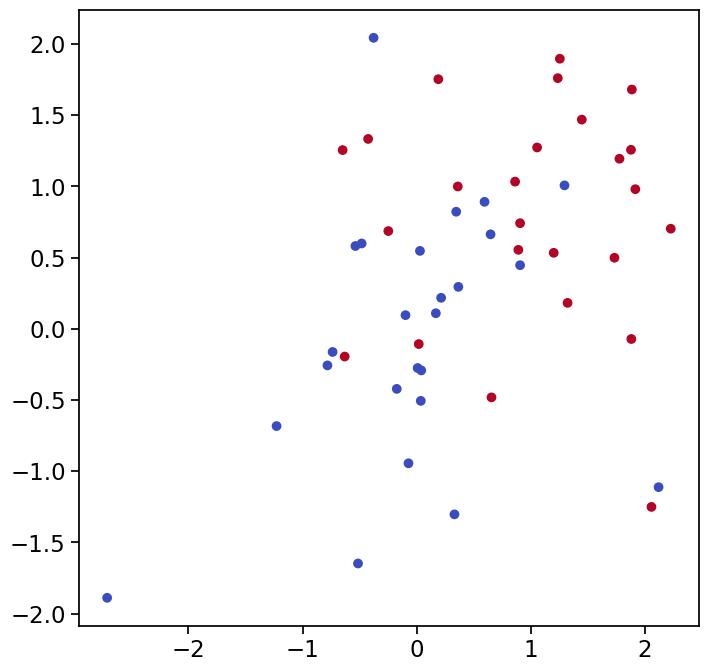

In [4]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);

它們不是線性可分離的。我們現在擬合分類器。

In [5]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

具有兩個特徵的支援向量分類器可以透過繪製其 *決策函數* 的值來視覺化。我們在 `ISLP` 套件中包含了一個 [`plot_svm()`](https://islp.readthedocs.io/en/latest/helpers/svm.html) 函數來完成此功能（靈感來自 `scikit-learn` 文件中的類似範例）。

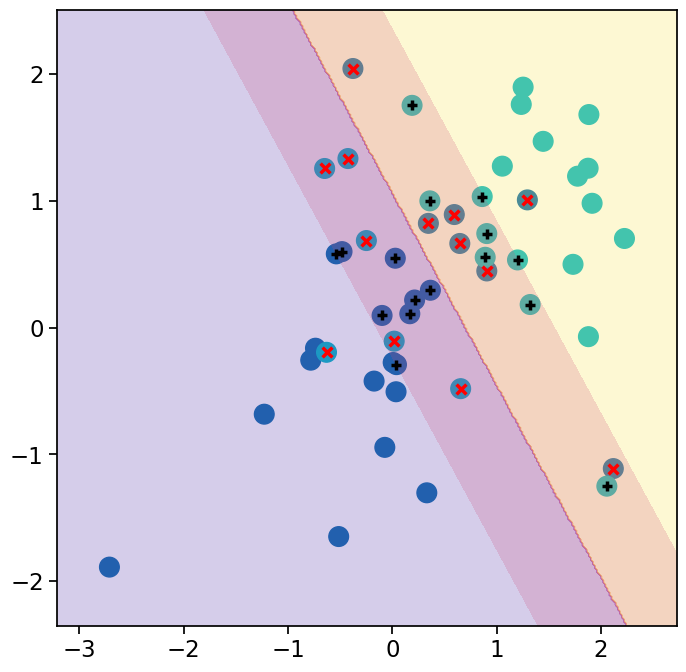

In [6]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear,
         ax=ax)

兩個類別之間的決策邊界是線性的（因為我們使用參數 `kernel='linear'`）。支援向量標記為 `+`，其餘觀測值繪製為圓形。

我們在此看到有 29 個支援向量。我們可以如下確定它們的身份：

In [7]:
# get support vectors
pd.DataFrame(svm_linear.support_vectors_, index=svm_linear.support_)

,0,1
0,0.345584,0.821618
2,0.905356,0.446375
3,-0.536953,0.581118
4,0.364572,0.294132
5,0.028422,0.546713
7,-0.482119,0.598846
8,0.039722,-0.292457
11,1.294064,1.006724
14,0.213643,0.217322
15,2.117839,-1.112021


In [8]:
# get indices of support vectors
svm_linear.support_

array([ 0,  2,  3,  4,  5,  7,  8, 11, 14, 15, 16, 17, 19, 22, 24, 25, 29,
       31, 32, 34, 36, 38, 39, 41, 43, 46, 47, 48, 49], dtype=int32)

In [9]:
# get number of support vectors for each class
svm_linear.n_support_

array([15, 14], dtype=int32)

如果我們改為使用較小的成本參數值會怎樣？

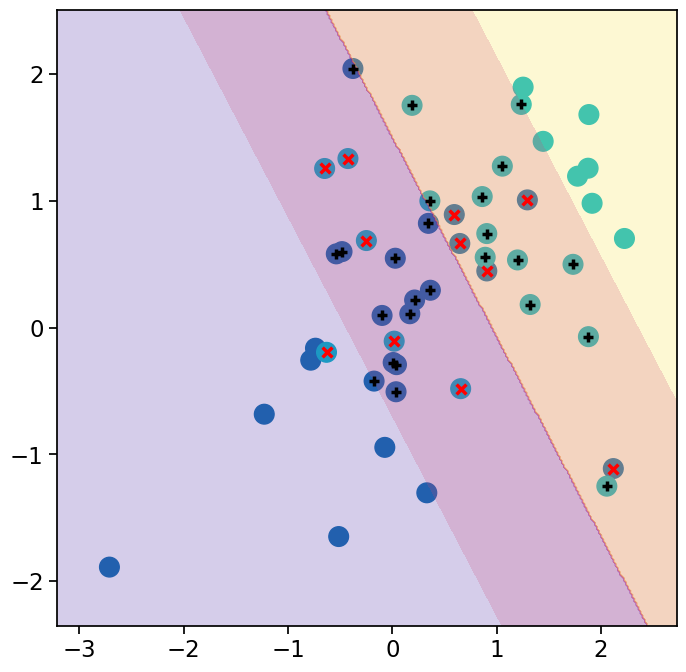

In [10]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear_small,
         ax=ax)

使用較小的成本參數值，我們獲得更多的支援向量，因為邊界現在更寬。

In [11]:
# get number of support vectors for each class
svm_linear_small.n_support_

array([18, 18], dtype=int32)

對於線性核，我們可以如下提取線性決策邊界的係數：

In [12]:
svm_linear.coef_

array([[1.17303943, 0.77348227]])

由於支援向量機是 `scikit-learn` 中的一個估算器，我們可以使用常見的機制來調參。

In [13]:
kfold = skm.KFold(5,
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001,0.01,0.1,1,5,10,100]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X, y)
grid.best_params_

{'C': 1}

我們可以在 `grid.cv_results_` 中輕易地存取這些模型的交叉驗證誤差。這會印出很多細節，所以我們只提取準確率結果。

In [14]:
grid.cv_results_[('mean_test_score')]

array([0.46, 0.46, 0.72, 0.74, 0.74, 0.74, 0.74])

我們看到 `C=1` 導致最高的交叉驗證準確率 0.74，儘管對於幾個 `C` 值，準確率都是相同的。分類器 `grid.best_estimator_` 可用於預測測試觀測集合的類別標籤。讓我們產生測試資料集。

In [15]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1]*10+[1]*10)
X_test[y_test==1] += 1

現在我們預測這些測試觀測值的類別標籤。在此我們使用透過交叉驗證選擇的最佳模型來進行預測。

In [16]:
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


因此，使用這個 `C` 值，70% 的測試觀測值被正確分類。如果我們改為使用 `C=0.001` 會怎樣？

In [17]:
svm_ = SVC(C=0.001,
           kernel='linear').fit(X, y)
y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,2,0
1,8,10


在此情況下，60% 的測試觀測值被正確分類。

我們現在考慮兩個類別線性可分離的情況。然後我們可以使用 `SVC()` 估算器找到最佳分離超平面。我們首先進一步分離模擬資料中的兩個類別，使它們線性可分離：

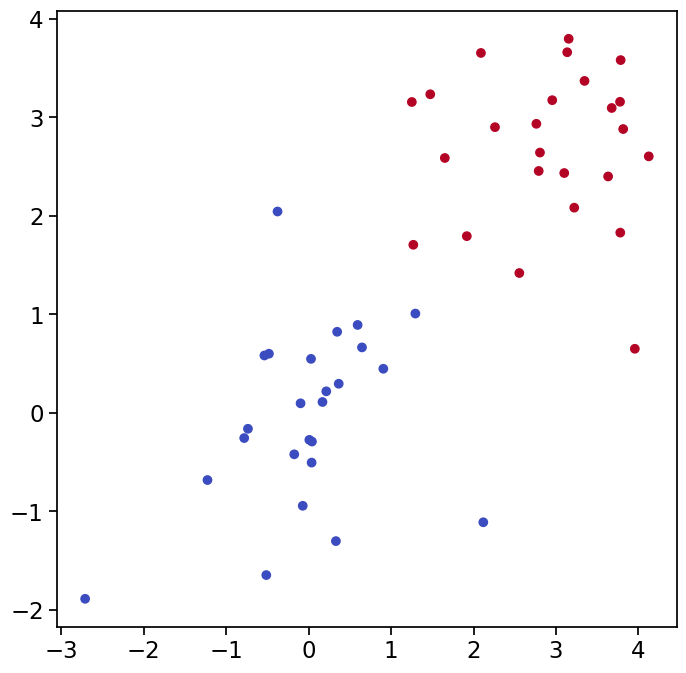

In [18]:
X[y==1] += 1.9;
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm);

現在觀測值剛好線性可分離。

In [19]:
svm_ = SVC(C=1e5, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


我們擬合支援向量分類器並繪製產生的超平面，使用非常大的 `C` 值，這樣就不會有觀測值被錯誤分類。

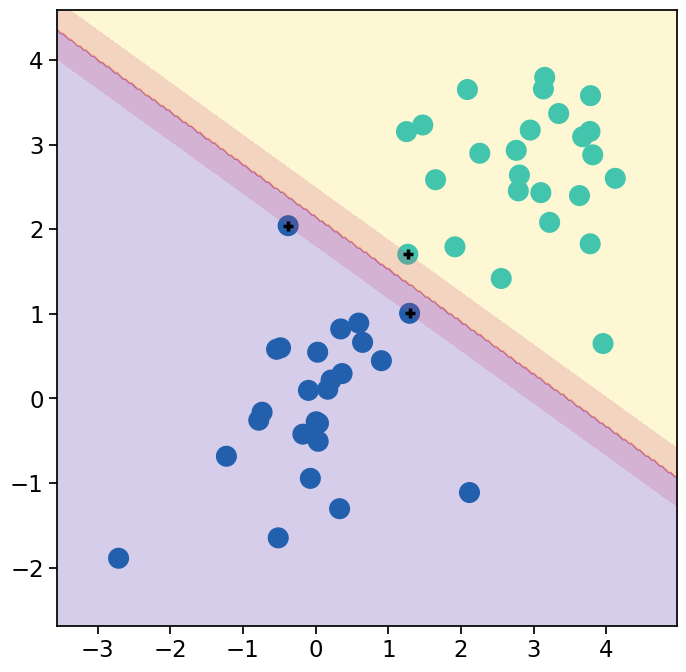

In [20]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_,
         ax=ax)

確實沒有產生訓練誤差，並且只使用了三個支援向量。事實上，`C` 的大值也意味著這三個支援點 *在邊界上*，並定義了邊界。人們可能會想知道僅依賴三個資料點的分類器在測試資料上能有多好！我們現在嘗試較小的 `C` 值。

In [21]:
svm_ = SVC(C=0.1, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


使用 `C=0.1`，我們再次沒有錯誤分類任何訓練觀測值，但我們也獲得了更寬的邊界並使用十二個支援向量。它們共同定義決策邊界的方向，由於數量更多，因此更穩定。看起來這個模型可能在測試資料上比 `C=1e5` 的模型表現更好（事實上，使用大型測試集的簡單實驗會證實這一點）。

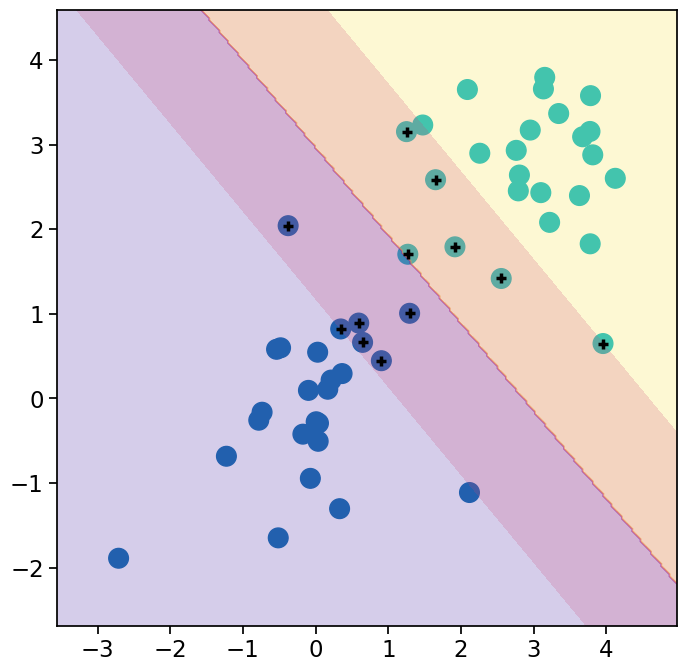

In [22]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_,
         ax=ax)

## 核方法

In [23]:
def feature_map_1(X):
    return np.asarray((np.sqrt(2)*X[:,0]*X[:,1], X[:,0]**2, X[:,1]**2)).T

def my_kernel_1(X,Y):
    return np.dot(feature_map_1(X),feature_map_1(Y).T )

w= [-0.05481854 -2.53191791 -2.52028513] b= [1.14976292]


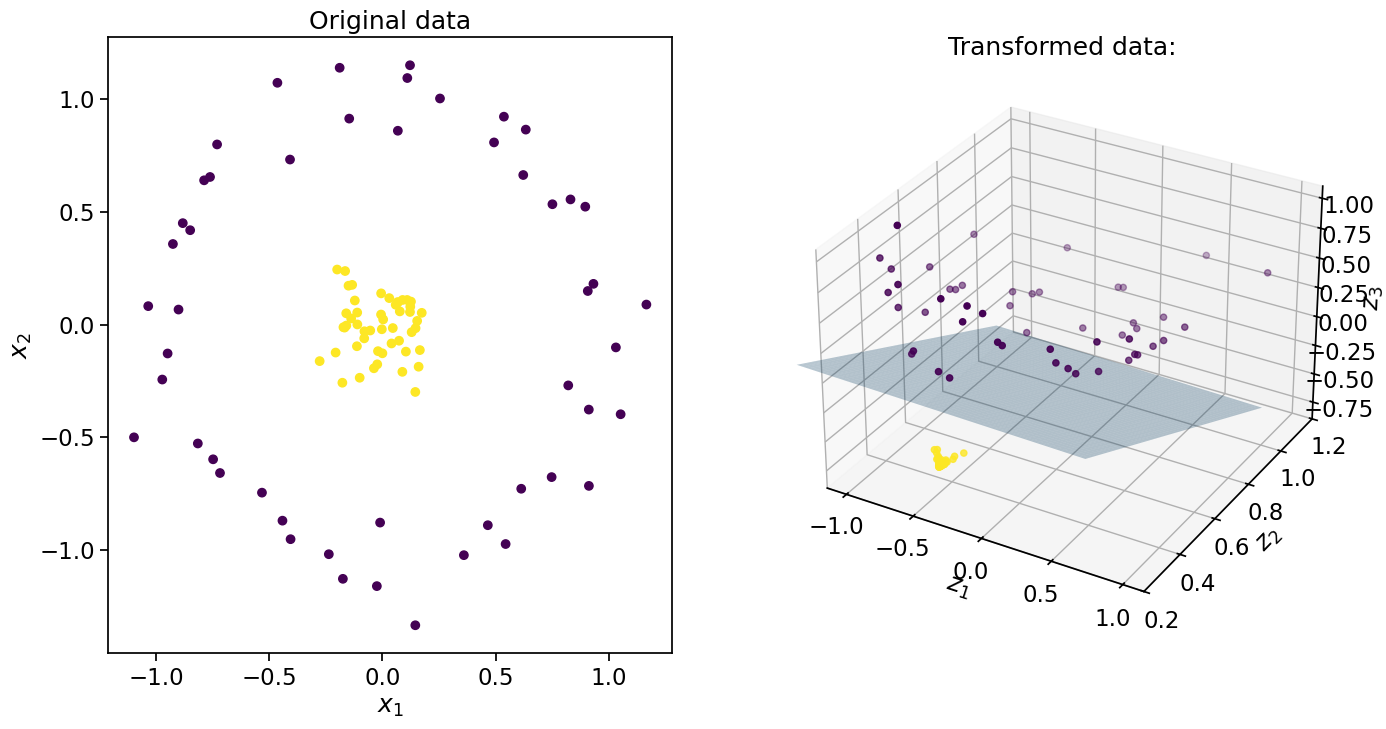

In [24]:
## Reference https://xavierbourretsicotte.github.io/Kernel_特徵_map.html

X, y = make_circles(100, factor=.1, noise=.1, random_state = 0)
Z = feature_map_1(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original data')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed data: ')

#SVM using linear kernel with 特徵 map 1
clf = SVC(C = 1, kernel = 'linear')
clf.fit(Z, y)

w = clf.coef_.flatten()
b = clf.intercept_.flatten()
print('w=',w,'b=',b)

# create x,y
xx, yy = np.meshgrid(np.linspace(-1,1), np.linspace(0,1))

# calculate corresponding z
# The equation of the separating plane is given by all x in R^3 such that:
# np.dot(w, x) + b = 0. We should solve for the last coordinate
boundary = (-w[0] * xx - w[1] * yy - b) * 1. /w[2]


# plot the surface

ax.plot_surface(xx, yy, boundary, alpha = .3)
ax.set_ylim(.2,1.2)
ax.set_zlim(-.9,1.1)
#ax.view_init(0, 260)

plt.show()

In [25]:
#SVM using kernel 1 - 特徵 map 1
clf2 = SVC(kernel=my_kernel_1)
clf2.fit(X, y)

# predict on training examples - print accuracy score
print('Accuracy score using feature map ',accuracy_score(y, clf2.predict(X)))
print('Accuracy score using feature map ',accuracy_score(y, clf.predict(Z)))

Accuracy score using feature map  1.0
Accuracy score using feature map  1.0


Text(0, 0.5, '$x_2$')

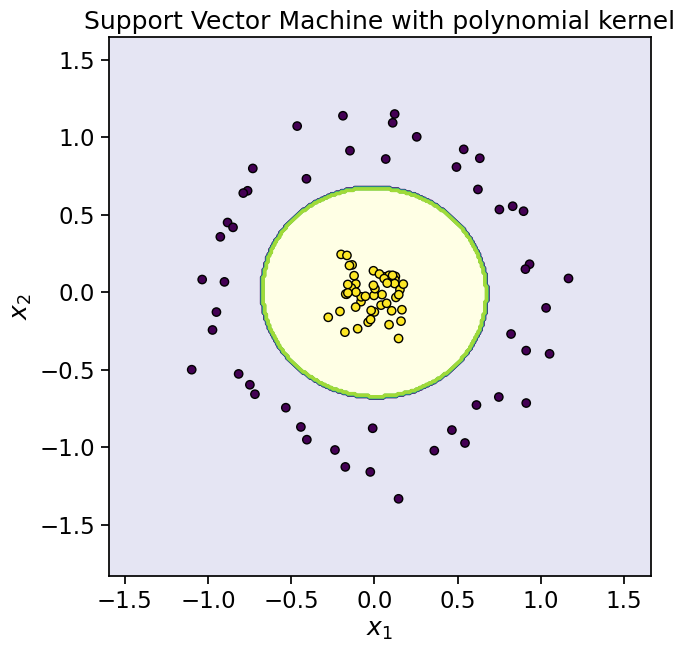

In [26]:
#Initialize data
h = .01 #Stepsize in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on meshgrid
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (7,7))
plt.contourf(xx, yy, Z, 1, colors = ['darkblue','yellow'], alpha = .1) # plot coutour surface
plt.contour(xx, yy, Z, cmap = 'viridis') # plot coutour line

# 繪圖 also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors = 'k')
plt.title('Support Vector Machine with polynomial'
          ' kernel')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## 支援向量機

為了擬合使用 **非線性核函數** 的 SVM，我們再次使用 `SVC()` 估算器。然而，現在我們使用參數 `kernel` 的不同值。要擬合具有多項式核的 SVM，我們使用 `kernel="poly"`，要擬合具有徑向基核的 SVM，我們使用 `kernel="rbf"`。在前一種情況下，我們也使用 `degree` 參數來指定多項式核的次數（這是 (9.22) 中的 $d$），在後一種情況下，我們使用 `gamma` 來指定徑向基核的 $\gamma$ 值 (9.24)。

我們首先產生一些具有非線性類別邊界的資料，如下所示：

In [27]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

繪製資料清楚地表明類別邊界確實是非線性的。

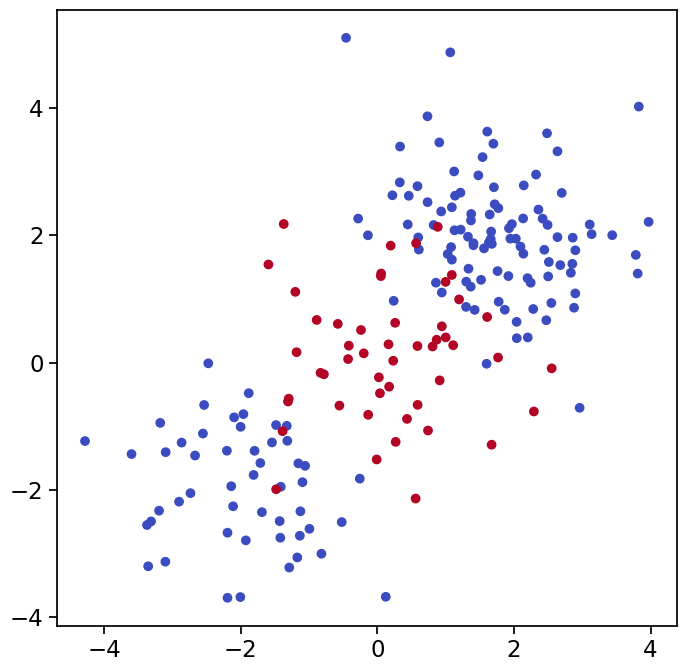

In [28]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);

資料被隨機分割為訓練組和測試組。然後我們使用具有徑向基核和 $\gamma=1$ 的 `SVC()` 估算器擬合訓練資料：

In [29]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.5,
                                random_state=0)
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train, y_train)

SVC(C=1, gamma=1)

圖形顯示產生的 SVM 具有明顯的非線性邊界。

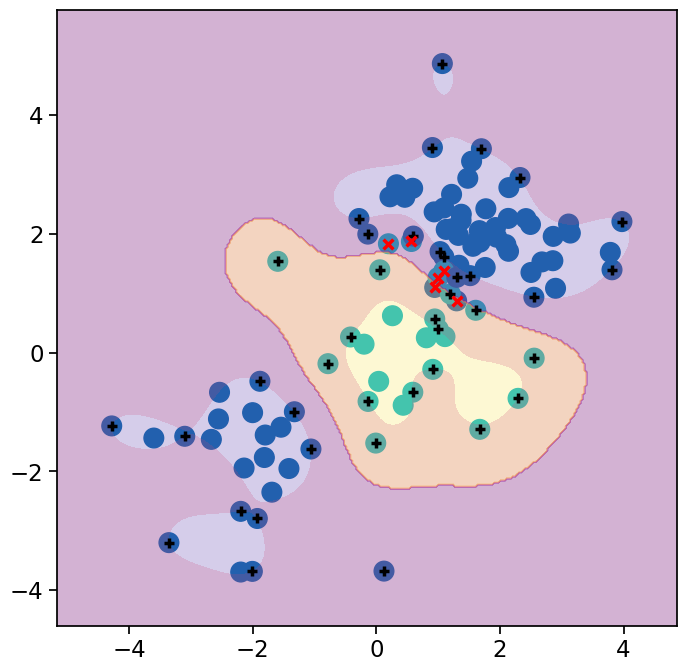

In [30]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         svm_rbf,
         ax=ax)

我們可以從圖中看到此 SVM 擬合中有相當數量的訓練誤差。如果我們增加 `C` 的值，我們可以減少訓練誤差的數量。然而，這會以更不規則的決策邊界為代價，似乎有過度擬合資料的風險。

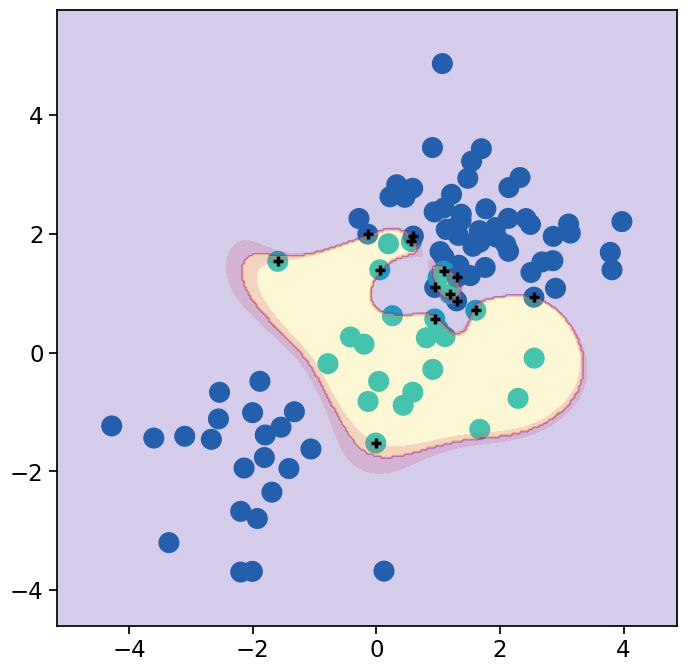

In [31]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         svm_rbf,
         ax=ax)

我們可以使用 `skm.GridSearchCV()` 進行交叉驗證，為具有徑向基核的 SVM 選擇 $\gamma$ 和 `C` 的最佳選擇：

In [32]:
kfold = skm.KFold(5,
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_rbf,
                        {'C':[0.1,1,10,100,1000],
                         'gamma':[0.5,1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train, y_train)
grid.best_params_

{'C': 1, 'gamma': 0.5}

在五摺交叉驗證下，參數的最佳選擇在 `C=1` 和 `gamma=0.5` 時達到，儘管其他幾個值也達到相同的值。

Truth,1,2
Predicted,,
1,69,6
2,6,19


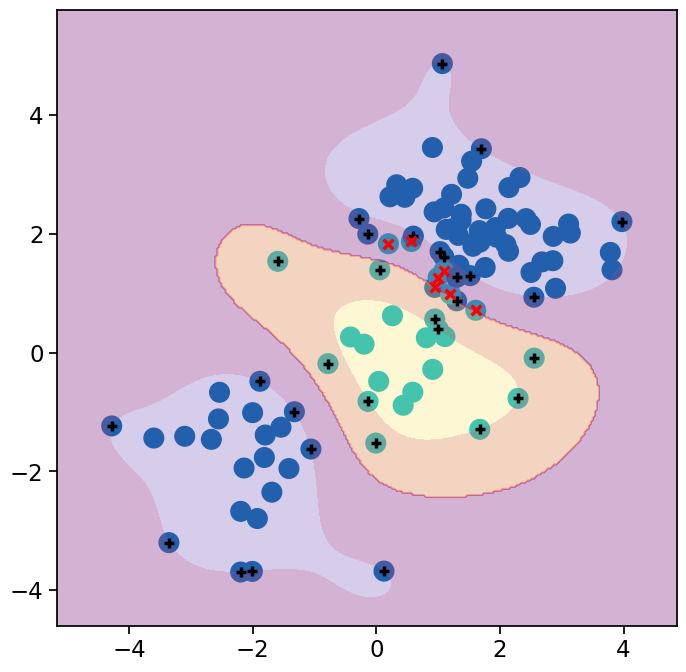

In [33]:
best_svm = grid.best_estimator_
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         best_svm,
         ax=ax)

y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)

使用這些參數，12% 的測試觀測值被此 SVM 錯誤分類。

## ROC 曲線

SVM 和支援向量分類器為每個觀測值輸出類別標籤。然而，也可以為每個觀測值獲得 *擬合值*，這些是用於獲得類別標籤的數值分數。例如，在支援向量分類器的情況下，觀測值 $X= (X_1, X_2, \ldots, X_p)^T$ 的擬合值採用形式 $\hat{\beta}_0 + \hat{\beta}_1 X_1 + \hat{\beta}_2 X_2 + \ldots + \hat{\beta}_p X_p$。對於具有非線性核的 SVM，產生擬合值的方程式在 (9.23) 中給出。擬合值的符號決定觀測值位於決策邊界的哪一側。因此，給定觀測值的擬合值與類別預測之間的關係很簡單：如果擬合值超過零，則觀測值被分配到一個類別；如果小於零，則被分配到另一個類別。透過將此閾值從零改變為某個正值，我們使分類偏向於一個類別而非另一個類別。透過考慮這些閾值的範圍（正值和負值），我們產生 ROC 圖的成分。我們可以透過呼叫擬合 SVM 估算器的 `decision_function()` 方法來存取這些值。

函數 `ROCCurveDisplay.from_estimator()`（我們簡稱為 `roc_curve()`）將產生 ROC 曲線圖。它以擬合的估算器作為第一個參數，接著是模型矩陣 $X$ 和標籤 $y$。參數 `name` 用於圖例，而 `color` 用於線條的顏色。結果繪製在我們的軸物件 `ax` 上。

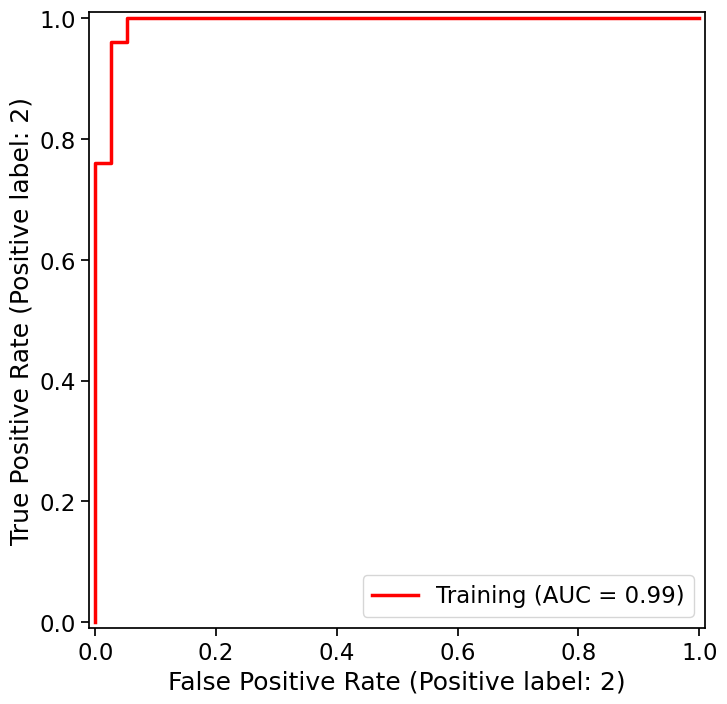

In [34]:
fig, ax = subplots(figsize=(8,8))
roc_curve(best_svm,
          X_train,
          y_train,
          name='Training',
          color='r',
          ax=ax)

在此範例中，SVM 似乎提供了準確的預測。透過增加 $\gamma$，我們可以產生更靈活的擬合並進一步提升準確率。

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3689473138.py:9: SyntaxWarning: invalid escape sequence '\g'
  name='Training $\gamma=50$',


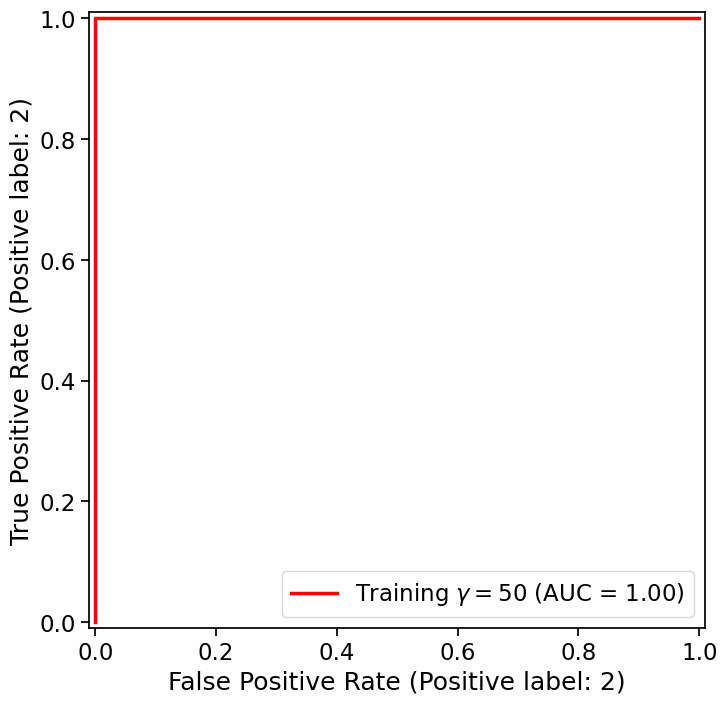

In [35]:
svm_flex = SVC(kernel="rbf",
              gamma=50,
              C=1)
svm_flex.fit(X_train, y_train)
fig, ax = subplots(figsize=(8,8))
roc_curve(svm_flex,
          X_train,
          y_train,
          name='Training $\gamma=50$',
          color='r',
          ax=ax);

然而，這些 ROC 曲線都是在訓練資料上的。我們真正更感興趣的是測試資料上的預測準確率水準。當我們在測試資料上計算 ROC 曲線時，$\gamma=0.5$ 的模型似乎提供最準確的結果。

In [36]:
roc_curve(svm_flex,
          X_test,
          y_test,
          name='Test $\gamma=50$',
          color='b',
          ax=ax)
fig;

<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3545933247.py:4: SyntaxWarning: invalid escape sequence '\g'
  name='Test $\gamma=50$',


讓我們看看我們調參後的 SVM。

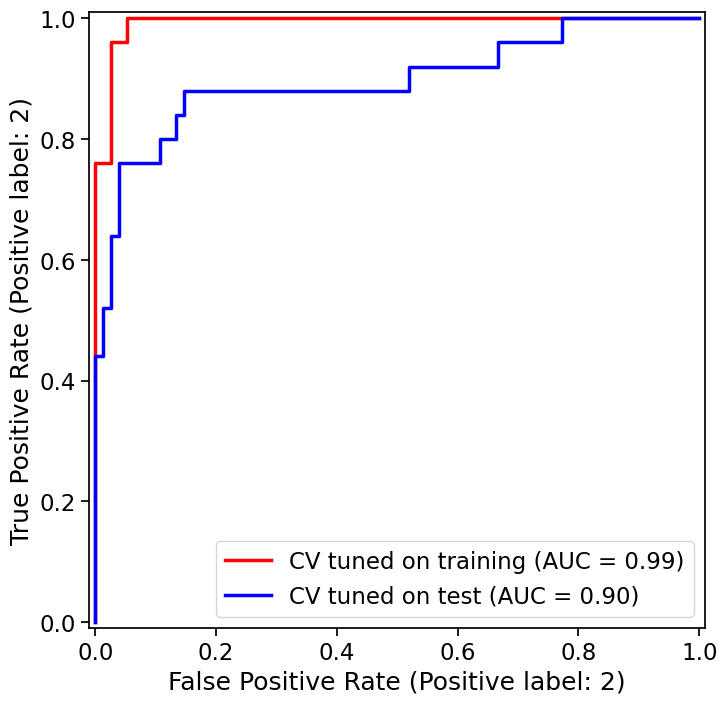

In [37]:
fig, ax = subplots(figsize=(8,8))
for (X_, y_, c, name) in zip(
     (X_train, X_test),
     (y_train, y_test),
     ('r', 'b'),
     ('CV tuned on training',
      'CV tuned on test')):
    roc_curve(best_svm,
              X_,
              y_,
              name=name,
              ax=ax,
              color=c)

## 多類別支援向量機

如果回應是包含兩個以上水準的因子，那麼 `SVC()` 函數將使用一對一方法（當 `decision_function_shape=='ovo'` 時）或一對其餘方法（當 `decision_function_shape=='ovr'` 時）進行多類別分類。注意：一對其餘也稱為一對全部。

我們透過產生第三類觀測值來簡要探索該設定。

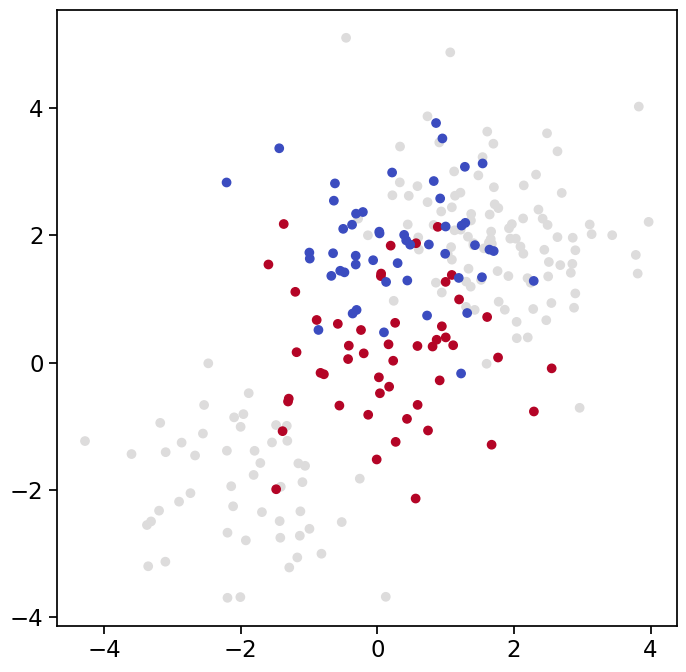

In [38]:
rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0]*50])
X[y==0,1] += 2
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm);

我們現在在資料上擬合 SVM：

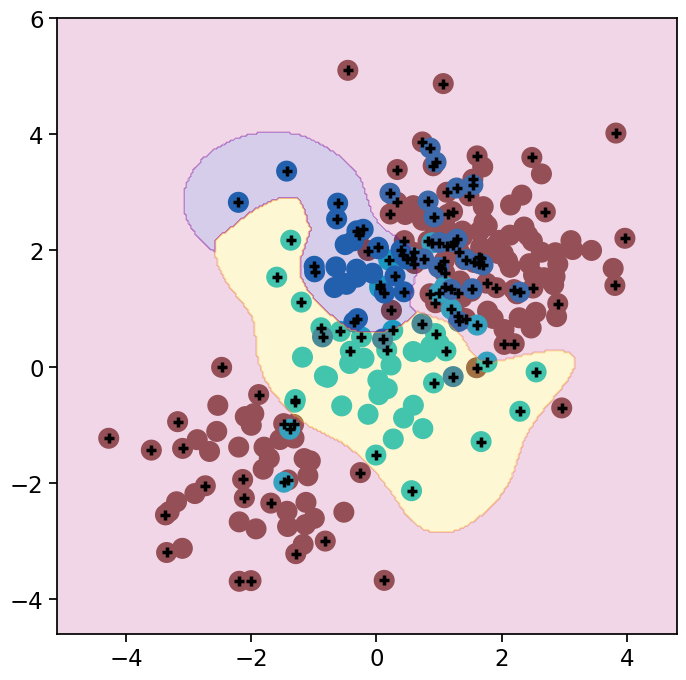

In [39]:
svm_rbf_3 = SVC(kernel="rbf",
                C=10,
                gamma=1,
                decision_function_shape='ovo');
svm_rbf_3.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_rbf_3,
         scatter_cmap=cm.tab10,
         ax=ax)

`scikit-learn.svm` 函式庫也可用於使用 `SupportVectorRegression()` 估算器執行具有數值回應的支援向量回歸。

## 基因表現資料的應用

我們現在檢查 [`Khan`](https://islp.readthedocs.io/en/latest/datasets/Khan.html) 資料集，該資料集包含對應於四種不同類型小圓藍細胞腫瘤的多個組織樣本。對於每個組織樣本，都有基因表現測量值。資料集包括訓練資料 `xtrain` 和 `ytrain`，以及測試資料 `xtest` 和 `ytest`。

我們檢查資料的維度：

In [40]:
Khan = load_data('Khan')
Khan['xtrain'].shape, Khan['xtest'].shape

((63, 2308), (20, 2308))

此資料集包含 2,308 個基因的表現測量值。訓練和測試集分別包含 63 和 20 個觀測值。

我們將使用支援向量方法來使用基因表現測量值預測癌症亞型。在此資料集中，相對於觀測值的數量，特徵數量非常大。這表明我們應該使用線性核，因為使用多項式或徑向基核所產生的額外靈活性是不必要的。

In [41]:
khan_linear = SVC(kernel='linear', C=10)
khan_linear.fit(Khan['xtrain'], Khan['ytrain'])
confusion_table(khan_linear.predict(Khan['xtrain']),
                Khan['ytrain'])

Truth,1,2,3,4
Predicted,,,,
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


我們看到 *沒有* 訓練誤差。事實上，這並不令人驚訝，因為相對於觀測值數量的大量變數意味著很容易找到完全分離類別的超平面。我們更感興趣的是支援向量分類器在測試觀測值上的表現。

In [42]:
confusion_table(khan_linear.predict(Khan['xtest']),
                Khan['ytest'])

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


我們看到在這些資料上使用 `C=10` 產生了兩個測試集誤差。

## SGD 分類器

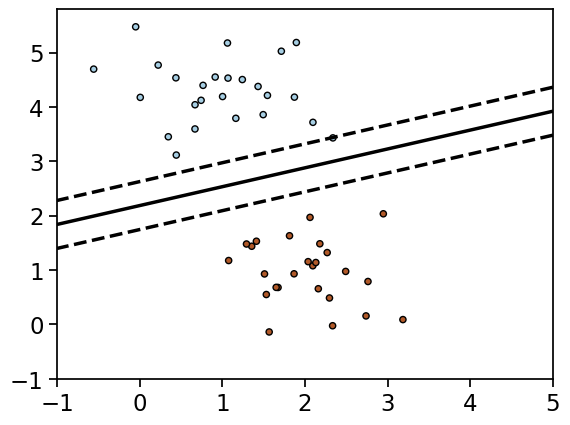

In [43]:
# we create 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)

clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolor="black", s=20)

plt.axis("tight")
plt.show()

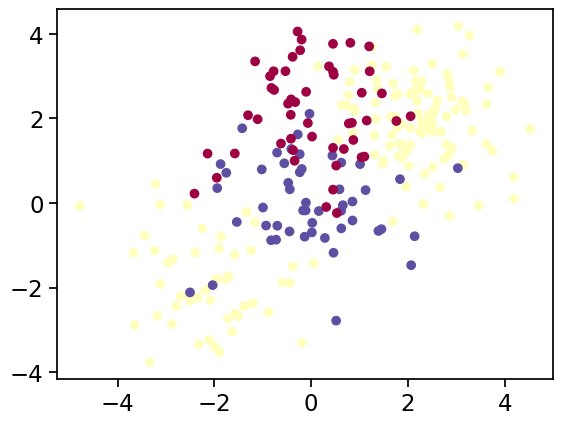

In [44]:
np.random.seed(1)

X = np.random.normal(size=400).reshape(200, 2)
X[0:100, :] += 2
X[100:150, :] -= 2
y = np.concatenate((np.full(150, 1, dtype=np.int64), np.full(50, 2, dtype=np.int64)))

X = np.concatenate((X, np.random.normal(size=100).reshape(50, 2)))
y = np.concatenate((y, np.full(50, 0, dtype=np.int64)))

X[y == 0, 1] += 2

plt.scatter(X[:, 0], X[:, 1], c=y+1, cmap='Spectral');

In [45]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X)
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)
clf.fit(X_features, y)
clf.score(X_features, y)

0.84